In [24]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import time
import copy

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# load modules related to this exercise

# load general packages
import numpy as np
# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 2

#### 1. Ensure that you understand the code zucher.sim_data

#### 2. Illustrate the likelihood function for different values of RC and c

In [25]:
# Simulate the data

# Set up
model = zurcher()
solver = solve_NFXP()

# update starting value: 
N = 500
T = 119
ev,pk = solver.poly(model.bellman, beta = model.beta, output=2)

# data
data = zurcher.sim_data(model,N,T,pk) 
samplesize = data.shape[0]


In [26]:
# Find tha likelihood value for different combinations 

par_RC = copy.copy(model.RC)
par_c = copy.copy(model.c)

NRC = 30
Nc = 20

log_lik = np.nan + np.zeros((NRC,Nc))
RC= np.linspace(8,15,NRC)
c = np.linspace(1,4,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p 
        tabulate = data.dx1.value_counts()
        p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]

        # STEP 2: Estimate structual parameters
        model.p = p # Use first step estimates as starting values for t
    
        # Estimate RC and C
        pnames = ['RC','c']
        theta = np.array([RC[i], c[j]])
        log_lik[i,j]=estimate.ll(theta,model, solver,data, pnames)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.RC = copy.copy(par_RC)
model.c = copy.copy(par_c)

/var/folders/d8/k9yj32vx0_76gfhvj06fhzzw0000gn/T/ipykernel_21916/1826355369.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, shrink=0.5, aspect=5)


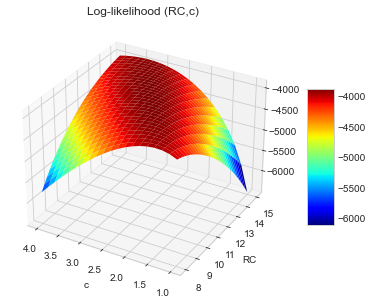

In [27]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(c, RC)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'c')
ax.set_ylabel(f'RC')
ax.set_title(f'Log-likelihood (RC,c)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### 3. Estimate the model, do you get the correct estimates?

In [28]:
nfxp_model, nfxp_res, nfxp_pnames, theta_hat, Avar, converged = estimate.estimate(model=model,solver=solver,data=data)

print(f"Zurcher params: \n {[par_RC,par_c]}")

print(f"NFXP model params: \n {theta_hat[:2]}")

/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp_ucph/2_dynamic_discrete_choice/exercises/ex_ante/estimate_NFXP.py:122: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  score = ((d - (1- lik_pr))[:,None])   * ( np.vstack((-np.ones(N), dc[x-1], np.zeros((n_p,N)))).T + np.broadcast_to(dev_dtheta[0],(N,2+n_p)) - dev_dtheta[x-1] )


Zurcher params: 
 [11.7257, 2.45569]
NFXP model params: 
 [11.69756624  2.45936569]


a) Try changing the starting values, does the model converges?

In [35]:
nfxp_model, nfxp_res, nfxp_pnames, theta_hat, Avar, converged = estimate.estimate(model=model,solver=solver,data=data,theta0=[20,20])

print(f'Log-Likelihood:     {-nfxp_res.fun*samplesize:.4f}')
print(f'RC:                 {theta_hat[0]:.4f}')
print(f'c:                  {theta_hat[1]:.4f}')

Log-Likelihood:     -63408.9324
RC:                 11.6976
c:                  2.4594


In [30]:
#starting values
rc_vec = np.array((0,12))
c_vec = np.array((0, 2, 40))

for i,rc in enumerate(rc_vec):
    for j, c in enumerate(c_vec):
        print(f'starting values: ({rc},{c})')
        t0 = time.time()
        
        # Update start values
        theta0 = [rc, c]
        
        # Estimate
        nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0)
        t1 = time.time()
        print(f'RC = {theta_hat[0]:.4f}, c = {theta_hat[1]:.4f}')
        print(f'The model converged: {converged}')
        print(f'Total time = {t1-t0:.4f} \n')

starting values: (0,0)
RC = 11.6976, c = 2.4594
The model converged: True
Total time = 0.8106 

starting values: (0,2)
RC = 11.6933, c = 2.4583
The model converged: True
Total time = 0.9863 

starting values: (0,40)
RC = 11.6976, c = 2.4594
The model converged: True
Total time = 0.9973 

starting values: (12,0)
RC = 11.6847, c = 2.4559
The model converged: True
Total time = 0.9799 

starting values: (12,2)
RC = 11.6976, c = 2.4594
The model converged: True
Total time = 0.4754 

starting values: (12,40)
RC = 11.6976, c = 2.4594
The model converged: True
Total time = 0.9414 



#### 4. What happen if you change the maximum number of Newton-Kantorovich iterations to 1? 
Do we get convergence? Do the estimates seem right? 


In [34]:
do_settings_solver = {
    'pi_max': 1,
    'pi_fxpiter': 1,  
    #'printfxp': 1
}

new_nfxp_solver = solve_NFXP(**do_settings_solver)

nfxp_model, nfxp_res, nfxp_pnames, theta_hat, Avar, converged = estimate.estimate(model=model,solver=new_nfxp_solver,data=data)

print(f'Log-Likelihood:     {-nfxp_res.fun*samplesize:.4f}')
print(f'RC:                 {theta_hat[0]:.4f}')
print(f'c:                  {theta_hat[1]:.4f}')


Log-Likelihood:     -63408.9324
RC:                 11.6976
c:                  2.4594
